In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import numpy as np
import os, sys
import matplotlib.pyplot as plt

from Airfoils import airfoil as af

from Software.Foil2Wake import runF2w as f2w
from Software.OpenFoam import runOpenFoam as of
from Software.Xfoil import runXFoil as xf
from Database import BASEFOIL2W , BASEOPENFOAM, DB2D

In [3]:
HOMEDIR = os.getcwd()

# Reynolds And Mach and AoA

In [4]:
def ms2mach(ms):
    return ms / 340.29

def Re(v, c, n):
    return (v * c) / n

In [5]:
chordMax = 0.18
chordMin = 0.11
umax = 30
umin = 5
ne = 1.56e-5

In [6]:
Machmin = ms2mach(10)
Machmax = ms2mach(30)
Remax = Re(umax, chordMax, ne)
Remin = Re(umin, chordMin, ne)
AoAmax = 15
AoAmin = -6
NoAoA = (AoAmax - AoAmin) * 2 + 1

angles = np.linspace(AoAmin, AoAmax, NoAoA)
Reynolds = np.logspace(np.log10(Remin), np.log10(Remax), 5, base=10)
Mach = np.linspace(Machmax, Machmin, 10)

Reyn = Reynolds[2]
MACH = Machmax
print(f"Nominal: Mach {MACH}\tReynolds {Reyn}")

Nominal: Mach 0.08816009873931058	Reynolds 110472.35858726977


In [7]:
cleaning = False
calcF2W = False
calcOpenFoam = False
calcXFoil = True

# Get Airfoil

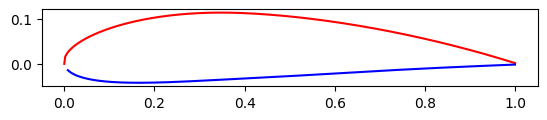

In [8]:
airf = af.AirfoilData.NACA('4415',n_points=200)
airf.accessDB(HOMEDIR,DB2D)
airf.plotAirfoil()

# Foil2Wake

In [9]:
ftrip_low = {"pos": 0.1, "neg": 0.2}
ftrip_up = {"pos": 0.2, "neg": 0.1}
Ncrit = 9
airf.reynCASE(Reyn)

if cleaning == True:
    airf.cleanRes(f2w.removeResults, [airf.REYNDIR, airf.HOMEDIR,angles])
if calcF2W == True:
    f2wargs = [airf.REYNDIR,airf.HOMEDIR,Reyn, MACH, ftrip_low, ftrip_up, angles, f"naca{airf.name}"]
    airf.setupSolver(f2w.setupF2W,[BASEFOIL2W,airf.HOMEDIR,airf.REYNDIR])
    airf.runSolver(f2w.runF2W,f2wargs)
airf.makePolars(f2w.makeCLCD2,"Foil2Wake",[airf.REYNDIR, airf.HOMEDIR])

Making Polars


# Xfoil

In [13]:
# LOOP
airfoils = ["4415", "0008"]
for airfoil in airfoils:
    airf = af.AirfoilData.NACA(airfoil, n_points=200)
    airf.accessDB(HOMEDIR, DB2D)
    
    print(f"\nRunning airfoil {airfoil}\n")
# if calcXFoil == True:
    for Rey in Reynolds:
        airf.reynCASE(Rey)
        print(
            f"#################################### {Rey} ######################################")

        print(airf.REYNDIR)
        xfargs = [airf.REYNDIR, HOMEDIR, Rey, MACH,
                    min(angles), max(angles), 0.5, airf.selig.T]
        XRES = airf.makePolars(xf.runAndSave, "XFOIL", xfargs)



Running airfoil 4415

#################################### 35256.41025641024 ######################################
/home/tryfonas/data/Uni/Semester9/Flight_Dynamics/Software/hermes/Database/2D/NACA4415/Reynolds_3.526e04
#################################### 62408.80383684699 ######################################
/home/tryfonas/data/Uni/Semester9/Flight_Dynamics/Software/hermes/Database/2D/NACA4415/Reynolds_6.241e04
#################################### 110472.35858726977 ######################################
/home/tryfonas/data/Uni/Semester9/Flight_Dynamics/Software/hermes/Database/2D/NACA4415/Reynolds_1.105e05
#################################### 195551.6090925112 ######################################
/home/tryfonas/data/Uni/Semester9/Flight_Dynamics/Software/hermes/Database/2D/NACA4415/Reynolds_1.956e05
#################################### 346153.84615384624 ######################################
/home/tryfonas/data/Uni/Semester9/Flight_Dynamics/Software/hermes/Database/2D/NACA441

In [11]:
print(XRES)

None


# OpenFoam

In [12]:
airf.reynCASE(Reyn)
os.chdir(airf.REYNDIR)
maxITER = 50
if cleaning == True:
    airf.cleanRes(of.cleanOpenFoam,[HOMEDIR,airf.REYNDIR])
if calcOpenFoam == True:
    ofSetupargs = [BASEOPENFOAM, airf.REYNDIR, airf.HOMEDIR,
                   airf.airfile, airf.fname, Reyn, MACH, angles]
    ofSetupkwargs = {"silent": True, "maxITER": maxITER}
    ofRunargs = [angles]
    airf.setupSolver(of.setupOpenFoam,ofSetupargs,ofSetupkwargs)
    airf.runSolver(of.runFoam,[airf.REYNDIR, airf.HOMEDIR, angles])
airf.makePolars(of.makeCLCD,"OpenFoam",[airf.REYNDIR, airf.HOMEDIR,angles])
